Minimal (2 layers, 3 nodes, 9 parameters) multi-layer perceptron that learns
the infamous XOR, implemented in vanilla Python (without numpy/pytorch/TF).

Hat tips for their explanations of back propagation:
* Rumelhart, Hinton, and Williams, "Learning representations by back-propagating errors" _Nature_ (1986)
* Michael A. Nielsen, "Neural networks and deep learning" http://neuralnetworksanddeeplearning.com/ (2015)

In [1]:
import math
import random
from typing import List, Callable, TypedDict

Activation and loss functions and their derivatives:

In [2]:
# activation function for hidden layers
def ReLU(z):
    '''rectified linear unit function, aka squash at zero'''
    return max(0, z)

# normalizing activation functions
def sigmoid(z):
    '''sigmoid function for binary classification'''
    exp_z = math.exp(z)          # benchmark: 10-15% faster to store exp(z) rather than calculate twice
    return exp_z / (1 + exp_z)   # alternate form for numerical stability; 1/(1+math.exp(-z)) will overflow

def softmax(V):
    '''transform an output vector of logits into a probability distribution'''
    shift_V = [n - max(V) for n in V]        # shift for numerical stability
    exp_V = [math.exp(n) for n in shift_V]   # exponentiate each logit
    return [n / sum(exp_V) for n in exp_V]   # normalize

# loss functions
def mse(y, y_predicted):
    '''quadratic cost function / mean squared error between y and ŷ'''
    return sum([math.pow(y - ŷ, 2) for y, ŷ in zip(y, y_predicted)])/len(y)

def log_loss(y, y_predicted):
    '''binary cross-entropy cost function for use with binary classification;
    penalizes confident incorrect predictions more heavily'''
    y_predicted = max(1e-15, min(1-1e-15, y_predicted))   # clip ŷ to [1e-15, 1-1e15] to avoid attempting log(0)
    #         (term vanishes if y = 0)      (term vanishes if y = 1)
    return -( (y*math.log(y_predicted)) + (1-y)*math.log(1-y_predicted) )

# derivatives of our activation functions, for backward propagation:
# ("what's the downstream sensitivity of the loss to this value")
def ReLU_derivative(a):
    return 1 if a > 0 else 0

def sigmoid_derivative(z):
    sig = sigmoid(z)
    return sig * (1-sig)

def log_loss_derivative(y, y_predicted):
    return -(y/y_predicted)+((1-y)/(1-y_predicted))


# map functions to their derivatives:
derivative = {
    ReLU: ReLU_derivative,
    sigmoid: sigmoid_derivative,
    log_loss: log_loss_derivative,
}

# inverse of our activation functions, for backward propagation
# alternatively, we could just store 'z' during the forward pass
# alternatively, we could use the special sigmoid a->dLda method
def sigmoid_inverse(a):
    return math.log(a/(1-a))

inverse = {
    sigmoid: sigmoid_inverse
}

Object oriented approach to constructing a neural network, with hierarchical network, layer, and node classes.

Pedagogically, this makes more transparent the structure of the network, at the cost of obscuring the math (in that the weights and biases are maintained within these objects, rather than directly passed between the computing functions in a more procedural approach).

This implementation is also (intentionally) extremely inefficient, using only Python data structures instead of numpy.

In [3]:
class Node:
    def __init__(self, L_index, N_index, in_nodes:int, activation_fx:Callable, bias:float = 0.):
        self.layer = L_index    # unused convenience
        self.node = N_index     # unused convenience
        self.bias = bias
        self.weights = [random.uniform(-0.25, 0.25) for _ in range(in_nodes)]
        self.activation_fx = activation_fx

    def activate(self, inputs:list):
        '''sum the bias and dot product, apply the node's activation function.'''
        a = self.bias
        for weight, input_signal in zip(self.weights, inputs):
            a += weight*input_signal
        return self.activation_fx(a)


class Layer:
    def __init__(self, L_index, in_nodes:int, nodes:int, afx:Callable):
        '''Construct a layer of `nodes` nodes, each with `in_nodes` weights'''
        self.nodes = [Node(L_index, N_index, in_nodes, afx) for N_index in range(nodes)]

    def activate(self, input:list):
        return [node.activate(input) for node in self.nodes]
    

class Net:
    def __init__(self, inputs:int, shape:List[int], activation_fxs:List[Callable]):
        '''Construct a deep net with `inputs` input nodes, where layer n has
        `shape[n]` nodes and `activation_fxs[n]` as its activation function.'''
        assert len(shape) == len(activation_fxs)
        shape.insert(0, inputs)
        self.layers = [Layer(i, shape[i], shape[i+1], activation_fxs[i]) for i in range(len(shape)-1)]

    def forward(self, x:List[float]) -> List[List[float]]:
        '''Given input `x`, compute activations for each node in the network by iterating through layers'''
        return [x := layer.activate(x) for layer in self.layers]
    
    class Gradients(TypedDict):
        weight: List[List[List[float]]]
        bias: List[List[float]]
    def backward(self, x:list, y, activations:List[list]) -> Gradients:
        '''Compute partial derivatives ("gradients") of the loss function w.r.t. every weight and bias, given the
        input `x`, expected output `y`, and `activations` from a forward pass. (The gradients tell us how a change to
        a weight/bias--while holding other parameters fixed--would change the loss.)'''

        # First, compute the loss (L) and the derivative of the loss with respect to our prediction (dLdŷ)
        # (FIXME: these three lines need to be generalized for networks with multiple output nodes)
        y_predicted = activations[-1][0]
        L = log_loss(y, y_predicted)    # unused?
        dLdŷ = derivative[log_loss](y, y_predicted)

        # create weight and bias gradient lists so we can index on them
        weight_grads = [[] for _ in range(len(self.layers))]
        bias_grads = [[] for _ in range(len(self.layers))]
        # initialize node gradient values to zero so we can accumulate on them
        node_grads = [[0] * len(self.layers[i].nodes) for i in range(len(self.layers))]
        # base case: derivative of the loss relative to our prediction
        node_grads[-1] = [dLdŷ]

        # iterate backwards through the layers
        for i in range(len(self.layers)-1, -1, -1):
            # for each node, its activation from the forward pass, and its gradient from the backward pass...
            for n, a, dLda in zip(self.layers[i].nodes, activations[i], node_grads[i]):
                # recover pre-activation value 'z' using the inverse of the activation function
                z = inverse[n.activation_fx](a)
                # compute da/dz (partial derivative of the node's activation w.r.t. the pre-activation value)
                dadz = derivative[n.activation_fx](z)    # (cheaper special case for sigmoid: dadz = a*(1-a))
                # compute dL/dz using the chain rule
                dLdz = dadz * dLda

                # Now distribute dLdz backwards to each component of z: bias, weights, and prior layer activations

                ### bias gradient ###
                # Since b is directly added into z, dz/db = 1, so by the chain rule, dL/db = 1 * dL/dz = dL/dz:
                bias_grads[i].append(dLdz)

                ### weight gradients ###
                # Since the weights scale an incoming signal (either an activation from the prior layer or an input),
                # the derivative of z w.r.t. the weight is just the value of that signal: dz/dw[j] = (a[i-1][j] or x[j])
                # Then, by the chain rule: dL/dw[j] = dz/dw[j] * dL/dz
                in_values = activations[i-1] if i != 0 else x
                weight_grads[i].append([dzdw * dLdz for dzdw in in_values])

                ### prior layer activation gradients ###
                # Likewise, the derivative of z w.r.t. the prior activation is just the weight: dz/da[i-1][j] = w[j]
                # However, because each node's activation can affect the loss via multiple downstream nodes, we must
                # accumulate all of these local effects to get the derivative of the loss: dL/da[i] += dz/da * dL/dz
                if i == 0:
                    # don't calculate gradients for the input (x); skip to the next node
                    continue
                for j in range(len(n.weights)):
                    dzda = n.weights[j]
                    dLda_increment = dzda * dLdz
                    node_grads[i-1][j] += dLda_increment

        return {'weight': weight_grads, 'bias': bias_grads}

In [4]:
xor_training = [
    # input x, output y
    {'x': (0,0), 'y': (0)},
    {'x': (1,0), 'y': (1)},
    {'x': (0,1), 'y': (1)},
    {'x': (1,1), 'y': (0)},
]

xor_net = Net(inputs=2, shape=[2, 1], activation_fxs=[sigmoid]*2)

In [5]:
def batch_train(net:Net, training_data, epochs, learning_rate=0.1):
    '''train network `net` using batch gradient descent with `training_data` for `epochs` batches'''
    
    for e in range(epochs):
        batch = []
        batch_loss = []
        shuffled_data = random.sample(training_data, len(training_data))

        # forward and backward passes to collect gradients for each sample
        for sample in shuffled_data:
            activations = xor_net.forward(sample['x'])
            gradients = xor_net.backward(sample['x'], sample['y'], activations)
            batch.append(gradients)
            if e == 0 or (e+1) % 1_000 == 0:
                batch_loss.append(log_loss(sample['y'], activations[-1][0]))

        if e == 0 or (e+1) % 1_000 == 0:
            print(f'epoch {e+1:{len(str(epochs))}d} loss={sum(batch_loss)/len(batch)}')
            batch_loss = []

        # get the average for each weight/bias gradient across all samples in the batch
        average_bias_grad = [[] for _ in range(len(net.layers))]
        average_weight_grads = [[] for _ in range(len(net.layers))]
        for layer in range(len(net.layers)):
            transposed_bias_grads = list(zip(*[batch[b]['bias'][layer] for b in range(len(batch))]))
            average_bias_grad[layer] = [sum(grads)/len(batch) for grads in transposed_bias_grads]

            average_weight_grads[layer] = [[] for _ in range(len(net.layers[layer].nodes))]
            for node in range(len(net.layers[layer].nodes)):
                transposed_weight_grads = list(zip(*[batch[b]['weight'][layer][node] for b in range(len(batch))]))
                average_weight_grads[layer][node] = [sum(grads)/len(batch) for grads in transposed_weight_grads]

        # nudge the weights in the opposite direction of the gradient (which points towards the steepest ascent of loss)
        for layer, layer_b_grads, layer_w_grads in zip(xor_net.layers, average_bias_grad, average_weight_grads):
            for node, b_grad, w_grads in zip(layer.nodes, layer_b_grads, layer_w_grads):
                node.bias += -b_grad * learning_rate
                for i in range(len((node.weights))):
                    node.weights[i] += -w_grads[i] * learning_rate
    
    for i,l in enumerate(xor_net.layers):
        for j,n in enumerate(l.nodes):
            print(f'layer {i+1}, node {j+1}, {n.weights=} {n.bias=}')

In [6]:
batch_train(xor_net, xor_training, epochs=10_000, learning_rate=0.5)

epoch     1 loss=0.6932200688166136
epoch  1000 loss=0.6931421543291335
epoch  2000 loss=0.6931343207318049
epoch  3000 loss=0.6931073550660427
epoch  4000 loss=0.6928133421563534
epoch  5000 loss=0.172186322942936
epoch  6000 loss=0.018983675959202216
epoch  7000 loss=0.009579831833111717
epoch  8000 loss=0.006365215830071819
epoch  9000 loss=0.004754930595380037
epoch 10000 loss=0.003790626420027121
layer 1, node 1, n.weights=[6.8414807129190445, -7.041154642607564] n.bias=-3.6424949487433933
layer 1, node 2, n.weights=[6.989559293765588, -6.715463365956175] n.bias=3.3439088056968767
layer 2, node 1, n.weights=[12.523369070517516, -12.033955864993512] n.bias=5.695534451852761


In [7]:
x, y = xor_training[3]['x'], xor_training[3]['y']
activations = xor_net.forward(x)
gradients = xor_net.backward(x, y, activations)
ŷ = activations[-1][0]
loss = log_loss(y, ŷ)

print(f'{x=}\n{y=}\n{ŷ=}\n{loss=}')

for i,l in enumerate(xor_net.layers):
    for j,n in enumerate(l.nodes):
        print(f'layer {i+1}, node {j+1}, {n.weights=} {n.bias=}')

print(f'{activations=}')
print(f'{gradients["weight"]=}')
print(f'{gradients["bias"]=}')

x=(1, 1)
y=0
ŷ=0.003138187924806085
loss=0.003143122362698382
layer 1, node 1, n.weights=[6.8414807129190445, -7.041154642607564] n.bias=-3.6424949487433933
layer 1, node 2, n.weights=[6.989559293765588, -6.715463365956175] n.bias=3.3439088056968767
layer 2, node 1, n.weights=[12.523369070517516, -12.033955864993512] n.bias=5.695534451852761
activations=[[0.020996717521010212, 0.9738651897521323], [0.003138187924806085]]
gradients["weight"]=[[[0.0008078592092034978, 0.0008078592092034978], [-0.0009611818360005362, -0.0009611818360005362]], [[6.589164538499861e-05, 0.003056171978869129]]]
gradients["bias"]=[[0.0008078592092034978, -0.0009611818360005362], [0.0031381879248060856]]


In [8]:
# use finite difference approximation to check our gradient algorithms:
e = 0.0001

# Layer 1 Node 1:
l1n1a = sigmoid(x[0] * xor_net.layers[0].nodes[0].weights[0] + \
                x[1] * xor_net.layers[0].nodes[0].weights[1] + \
                       xor_net.layers[0].nodes[0].bias)
# Layer 1 Node 2:
l1n2a = sigmoid(x[0] * xor_net.layers[0].nodes[1].weights[0] + \
                x[1] * xor_net.layers[0].nodes[1].weights[1] + \
                       xor_net.layers[0].nodes[1].bias)
# Layer 2 Node 1 (output node):
y_hat = sigmoid(l1n1a * xor_net.layers[1].nodes[0].weights[0] + \
                l1n2a * xor_net.layers[1].nodes[0].weights[1] + \
                        xor_net.layers[1].nodes[0].bias)
loss = log_loss(y, y_hat)


# introduce a difference to some one term:
l1n1a = sigmoid(x[0] * (xor_net.layers[0].nodes[0].weights[0] + 0) + \
                x[1] * xor_net.layers[0].nodes[0].weights[1] + \
                       xor_net.layers[0].nodes[0].bias + 0)
l1n2a = sigmoid(x[0] * (xor_net.layers[0].nodes[1].weights[0] + e) + \
                x[1] * xor_net.layers[0].nodes[1].weights[1] + \
                       xor_net.layers[0].nodes[1].bias)
y_hat = sigmoid(l1n1a * xor_net.layers[1].nodes[0].weights[0] + \
                l1n2a * xor_net.layers[1].nodes[0].weights[1] + \
                        xor_net.layers[1].nodes[0].bias)
loss_e = log_loss(y, y_hat)

print (f'dL/d[e] = {(loss_e - loss)/e}')


dL/d[e] = -0.0009611216191668381


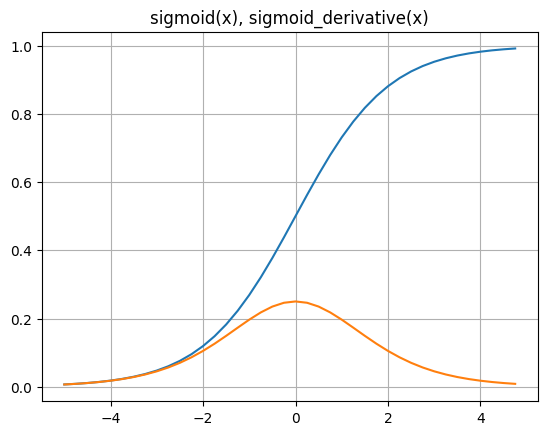

In [9]:
import matplotlib.pyplot as plt

x = [-5 + 0.25*i for i in range(40)]
s = [sigmoid(n) for n in x]
sd = [sigmoid_derivative(n) for n in x]
plt.plot(x, s)
plt.plot(x, sd)
plt.title('sigmoid(x), sigmoid_derivative(x)')
plt.grid(True)
plt.show()